In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [17]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

In [41]:
import datetime as dt
from datetime import datetime,timedelta
from itertools import chain

# Reflect Tables into SQLAlchemy ORM

In [42]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [43]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [44]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [45]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [47]:
#check columns in each table
inspector = inspect(engine)
columns = inspector.get_columns("measurement")

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [48]:
#check columns in each table
inspector = inspect(engine)
columns = inspector.get_columns("station")

for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [49]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [50]:
# Calculate the date 1 year ago from the last data point in the database
#need last year before precip data
last_date = (engine.execute("SELECT date FROM measurement ORDER BY date DESC").first())[0]
print(last_date)

year, month, day = map(int, last_date.split("-"))
year_ago = dt.datetime(year, month, day) - timedelta(365)
# year_ago = year_ago.strftime("%Y-%m-%d")
print(year_ago)



2017-08-23
2016-08-23 00:00:00


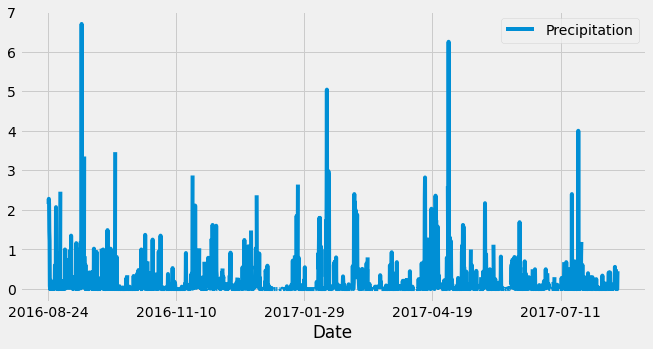

In [85]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_year_precip = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago).all()
# print(last_year_precip)
 

# Perform a query to retrieve the data and precipitation scores
date = [row[0] for row in last_year_precip]
precip = [row[1] for row in last_year_precip]

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame({"Date" : date,
                           "Precipitation" : precip}).set_index("Date")
# climate_df


# Sort the dataframe by date
climate_df = climate_df.sort_values("Date")
# climate_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
climate_df.plot(figsize = (10,5))
plt.xlabel("Date")
# plt.tick_params(
#     axis="x",
#     which="both",
#     labelbottom=False)
plt.legend(loc = "best")
plt.show()


In [68]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [70]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.name)).all()

[(9)]

In [72]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
engine.execute("SELECT station, count(station) AS count FROM measurement GROUP BY station ORDER BY count desc").fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [76]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
engine.execute("SELECT min(tobs), max(tobs), avg(tobs) FROM measurement WHERE station = 'USC00519281'").fetchall()

[(54.0, 85.0, 71.66378066378067)]

In [83]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = engine.execute("SELECT tobs FROM measurement WHERE date >= '2016-8-23' AND station = 'USC00519281'").fetchall()
data = [row[0] for row in data]
hist_data = pd.DataFrame({"tobs": data})
hist_data.head()

,tobs
0,72.0
1,70.0
2,64.0
3,63.0
4,63.0


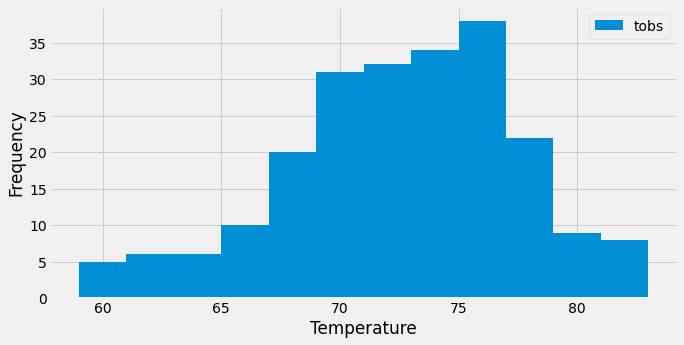

In [86]:
hist = hist_data.hist(bins = 12, figsize = (10, 5))
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("")
plt.legend(["tobs"])
plt.show()

## Bonus Challenge Assignment

In [77]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
